Импортируем необходимые библиотеки


In [69]:
import os
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
                       
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 12)  

In [28]:
f = pd.read_excel('Звонки 01-10.xlsx')

Соберём в датафрейм только содержимое столбца "Параметры", так как там совсем не понятно какое поле за что отвечает.

Чтобы понять сколько раз звонил телефон за день мы просто будем считать количество упоминаний той или иной даты в табличке


In [29]:
f = pd.DataFrame(f['Параметры:'])

In [30]:
f = f.sort_values(by ='Параметры:' )

Удаляем всё что не дата

In [31]:
f = f[:-22]

In [32]:
f['Параметры:'] = pd.to_datetime(f['Параметры:'], format = "%d.%m.%Y")
f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1831 entries, 978 to 1543
Data columns (total 1 columns):
Параметры:    1831 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 28.6 KB


In [50]:
f = pd.DataFrame(f['Параметры:'].value_counts())
f

,Параметры:
2018-04-02,19
2018-04-26,15
2018-05-14,14
2018-04-03,14
2018-03-26,13
2018-01-25,13
2018-04-16,13
2018-05-15,13
2018-07-05,13
2018-08-24,13


In [52]:
f = f.sort_index()

Посмотрим как распределяется количество заявок по дням. Какое число заявок является модой и медианой для набора данных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1bcaba20>]], dtype=object)

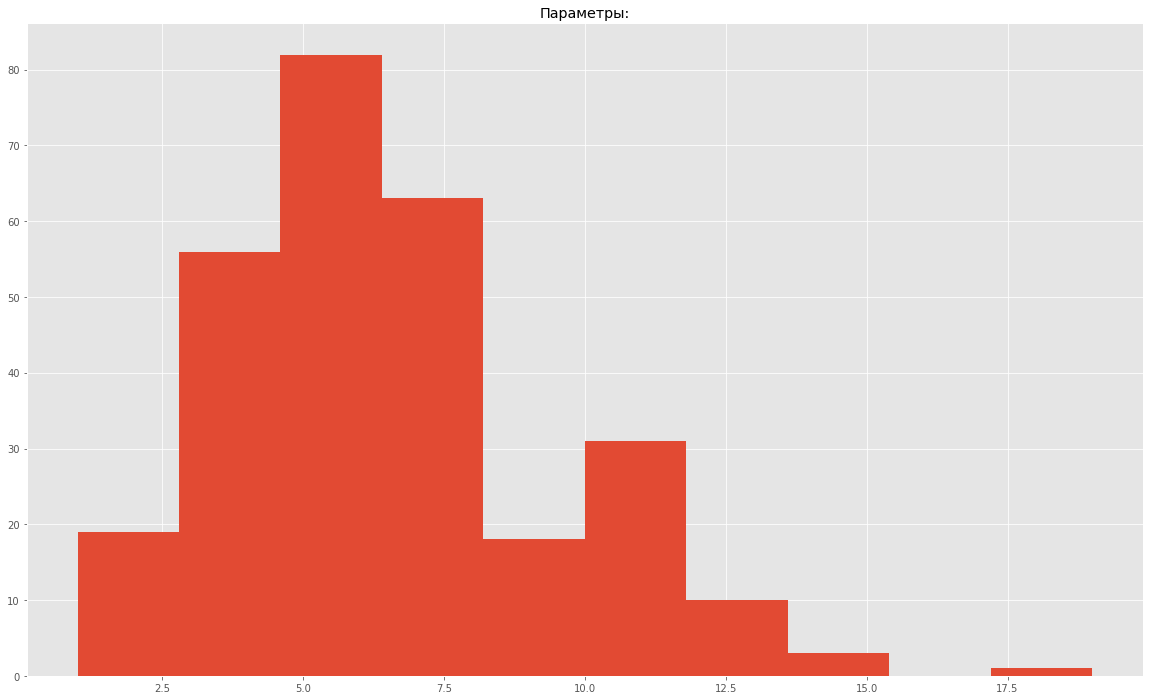

In [56]:
f.hist(bins = 10)

### Средним количеством является 5 звонков в день

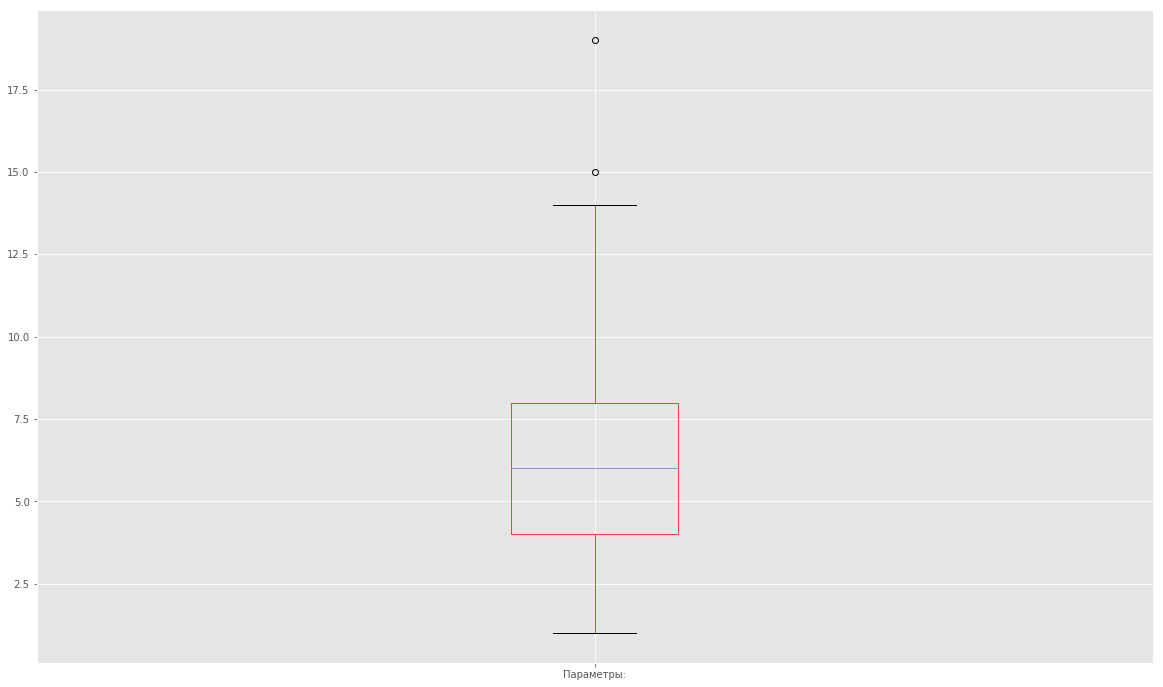

In [57]:
f.boxplot()

На графике "ящик с усами" мы можем видеть выбросы за пределы матожидания - 15 и 20 звонков в день

In [59]:
# Переименуем наш столбец в calls

f.columns = ['calls']

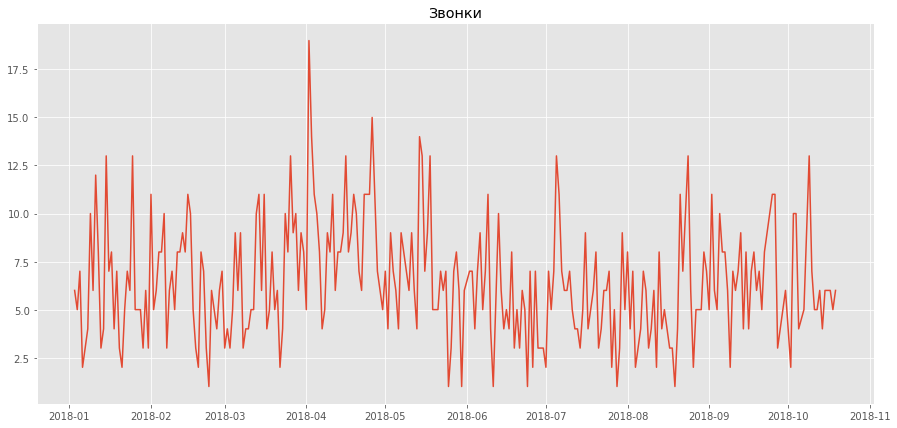

In [60]:
plt.figure(figsize=(15, 7))
plt.plot(f.calls)
plt.title('Звонки')
plt.grid(True)
plt.show()

## Из графика количества звонков по дням видим, что их объём приблизительно статичен

# Исследуем ряд данных скользящим средним

In [61]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [70]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "g--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "g--")
        
        # а имея доверительные интервалы, можно искать аномальные значения
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

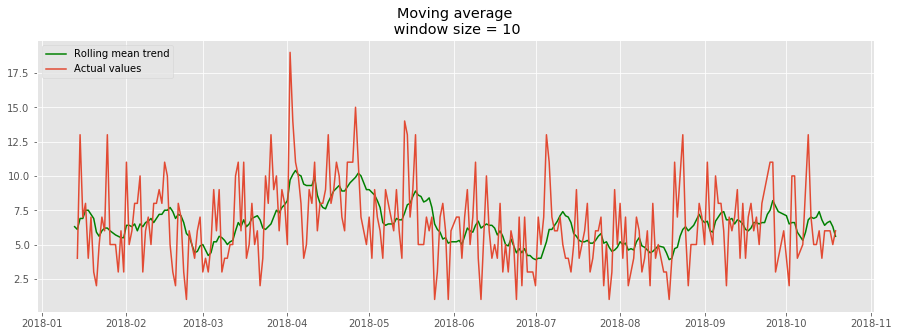

In [71]:
plotMovingAverage(f, 10)

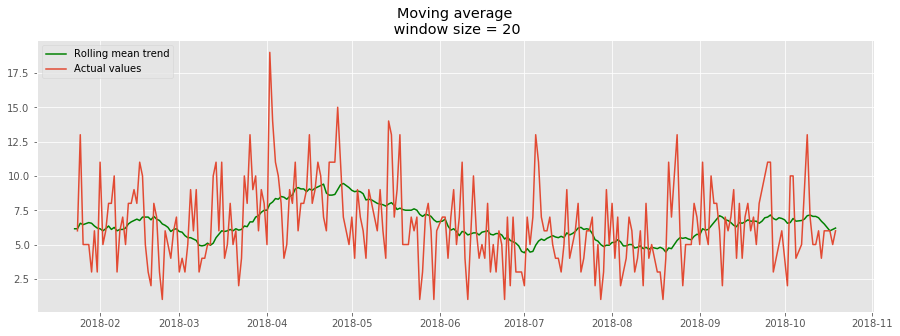

In [74]:
plotMovingAverage(f, 20)

### при сглаживании ряда средним по 20 последним дням можно заметить незначительный рост заявок с июля 2018

посмотрим на аномалии

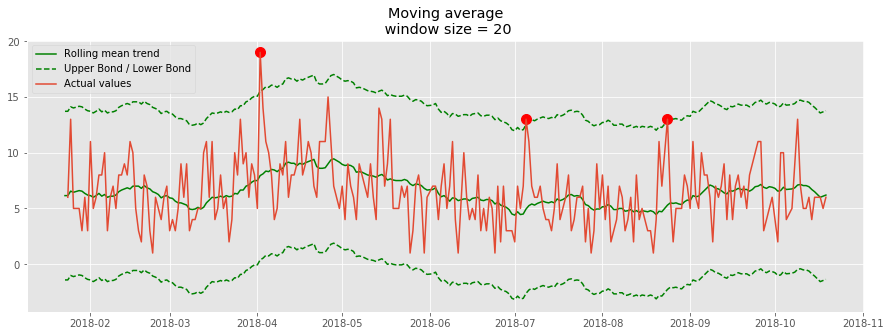

In [76]:
plotMovingAverage(f, 20, plot_intervals=True, plot_anomalies=True)

## Экспоненциальное сглаживание

А теперь посмотрим, что произойдёт, если вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого [экспоненциального сглаживания](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):

$$\hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [78]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # первое значение такое же, как в исходном ряде
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [79]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

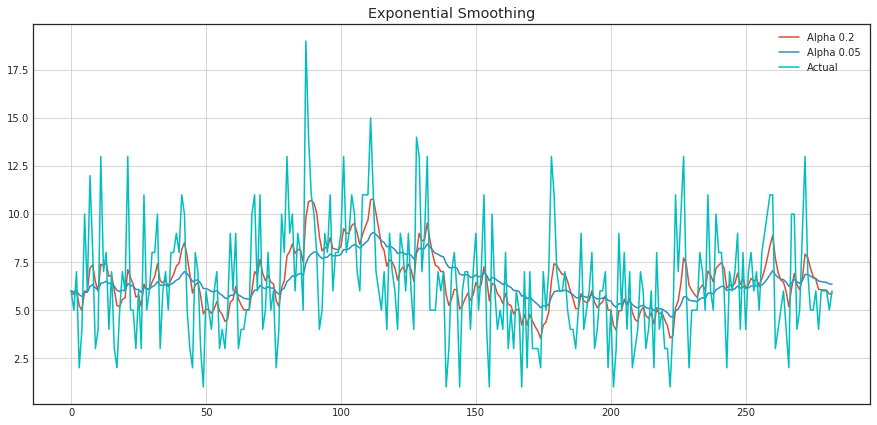

In [80]:
plotExponentialSmoothing(f.calls, [0.2, 0.05])

## Двойное экспоненциальное сглаживание

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед (и тоже красиво сглаживать ряд).

В этом нам поможет разбиение ряда на две составляющие - уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

В результате получаем набор функций. Первая описывает уровень - он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд - он зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [81]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # первое значение такое же, как в исходном ряде
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

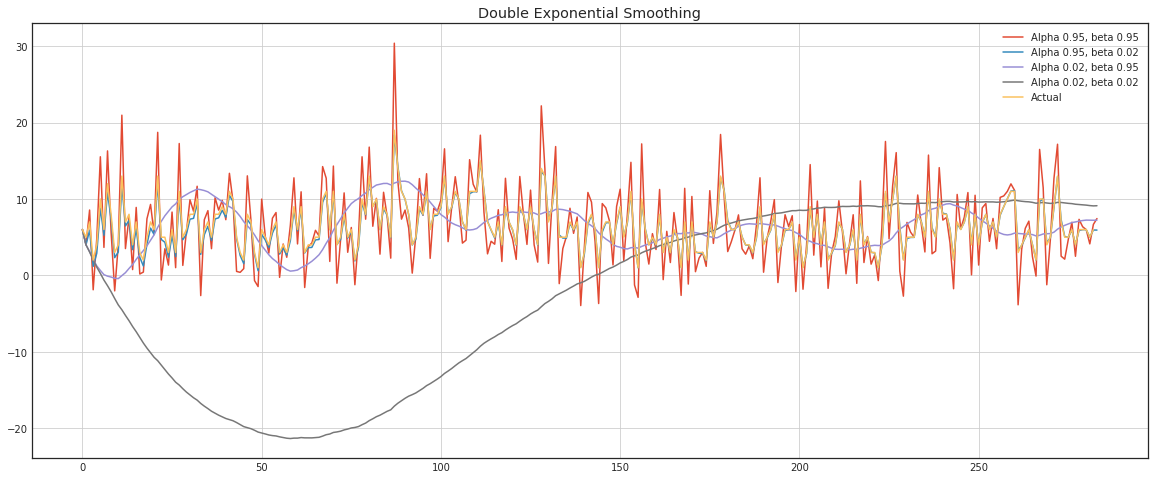

In [83]:
plotDoubleExponentialSmoothing(f.calls, alphas=[0.95, 0.02], betas=[0.95, 0.02])

## Короче динамика звонков - ПРЯМАЯ ЛИНИЯ

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

Итак, успешно добрались до следующего варианта экспоненциального сглаживания, на сей раз тройного.

Идея этого метода заключается в добавлении еще одной, третьей, компоненты - сезонности. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона - периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем новую систему:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, от и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать [здесь](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд, что не может не радовать. 

Ниже импортируем класс для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей - Чарльза Хольта и его студента Питера Винтерса. 
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$$

где $T$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

In [84]:
from sklearn.model_selection import TimeSeriesSplit 
from HoltWinters import HoltWinters                 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [106]:
%%time
data = f.calls[:300] # отложим 300 наблюдений для тестирования
slen = 20 # 30 дневная сезонность
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_squared_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.243762330454 0.00183959538713 0.148563908284
CPU times: user 2.96 s, sys: 11.1 ms, total: 2.97 s
Wall time: 2.97 s


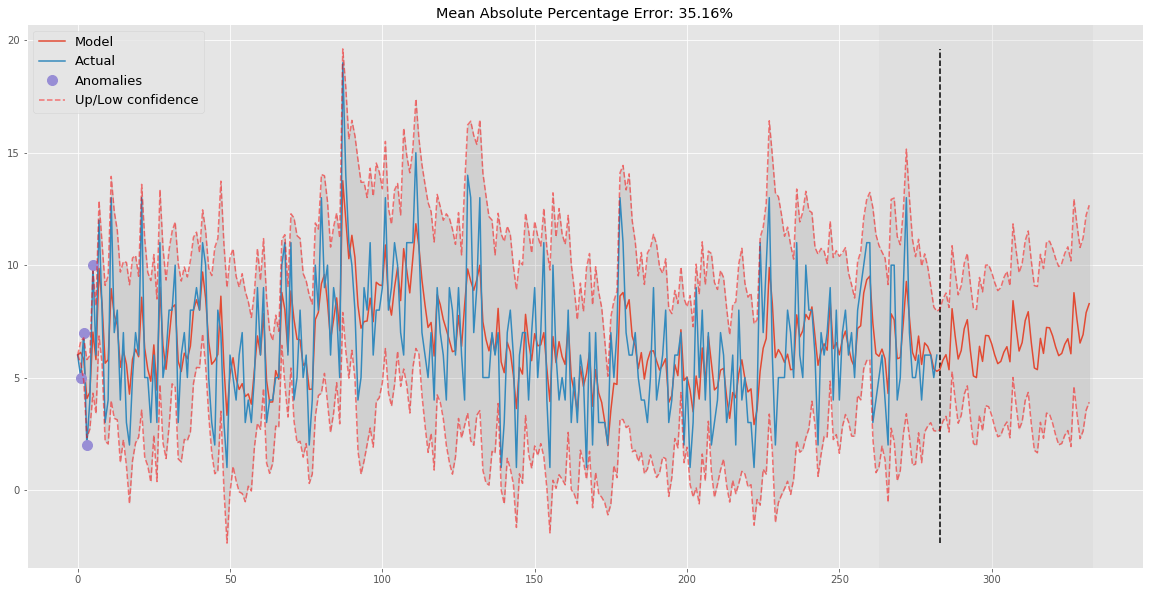

In [107]:
plotHoltWinters( f.calls[:300], plot_intervals=True, plot_anomalies=True)

### Стационарность

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как [**стационарность**](https://ru.wikipedia.org/wiki/Стационарность). 
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- Временной ряд справа не является стационарным, так как его матожидание со временем растёт

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Здесь не повезло с дисперсией - разброс значений ряда существенно варьируется в зависимости от периода

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Наконец, на последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.


## Избавляемся от нестационарности и строим SARIMA

Попробуем теперь построить SARIMA модель, пройдя все ~~круги ада~~ стадии приведения ряда к стационарному виду. Подробно про саму модель можно почитать здесь - [Построение модели SARIMA с помощью Python+R](https://habrahabr.ru/post/210530/), [Анализ временных рядов с помощью python](https://habrahabr.ru/post/207160/)

In [108]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

Критерий Дики-Фуллера: p=0.000166


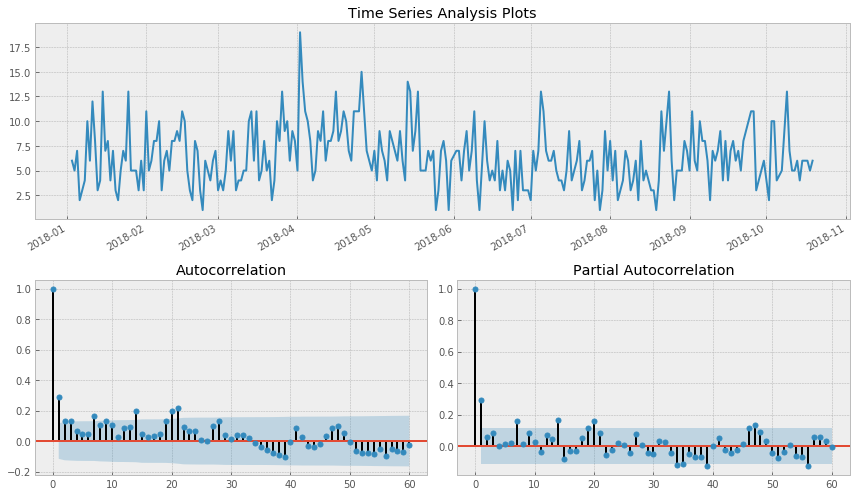

In [109]:
tsplot( f.calls, lags=60)

Критерий Дики-Фуллера: p=0.000000


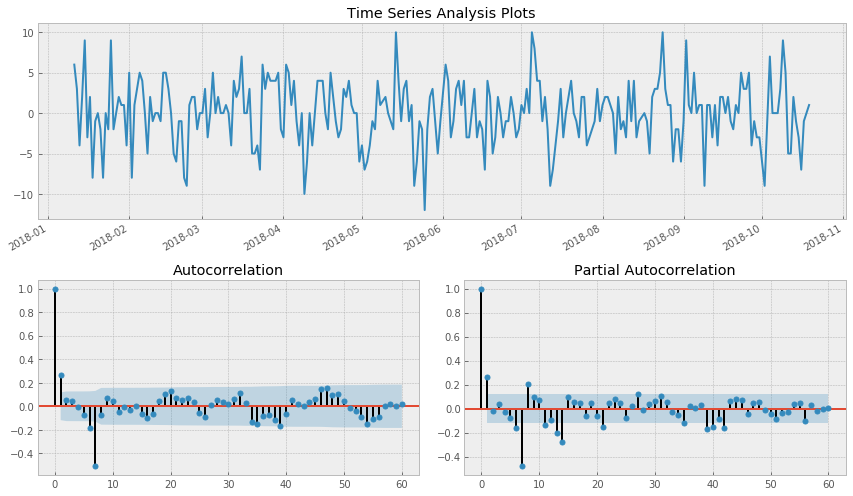

In [113]:
calls_diff = f.calls - f.calls.shift(7)
tsplot(calls_diff[7:], lags=60)

Оказывается сезонность у нас недельная

Критерий Дики-Фуллера: p=0.000000


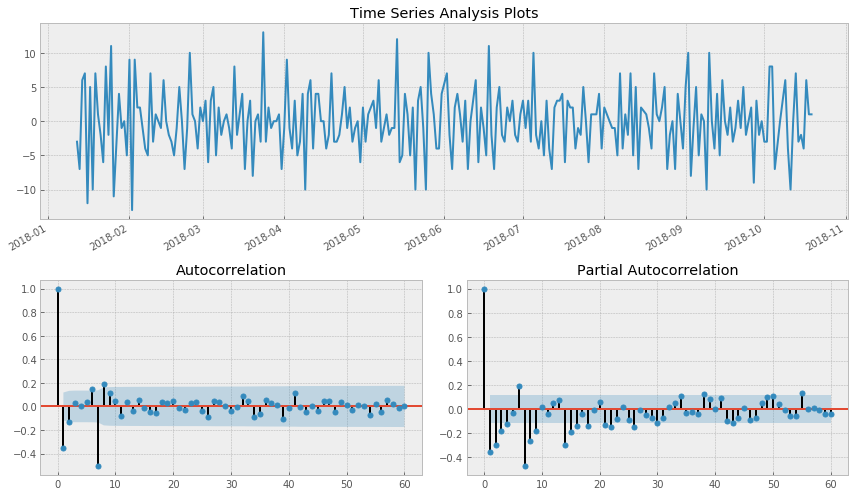

In [114]:
calls_diff = calls_diff - calls_diff.shift(1)
tsplot(calls_diff[7+1:], lags=60)

In [115]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(2, 5)
d=1 # тут мы уверены, дифференцировали один раз
qs = range(2, 5)

Ps = range(0, 3)
D=1 # здесь тоже уверены, сезонное дифференцирование было одно
Qs = range(0, 2)
s = 7

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [117]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX( f.calls, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [118]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


CPU times: user 38.5 s, sys: 276 ms, total: 38.8 s
Wall time: 21.4 s


In [119]:
result_table.head()

,parameters,aic
0,"(4, 4, 0, 1)",1385.900082
1,"(2, 4, 0, 1)",1387.148465
2,"(2, 4, 1, 1)",1387.232755
3,"(2, 4, 2, 1)",1387.325847
4,"(4, 4, 1, 1)",1388.708540


In [120]:
# передаём параметры с минимальным AIC
p, q, P, Q = result_table.parameters[0]

In [122]:
%%time

# обучаем лучшую модель

best_model=sm.tsa.statespace.SARIMAX( f.calls, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

CPU times: user 2.2 s, sys: 13.1 ms, total: 2.21 s
Wall time: 1.36 s


In [123]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             calls   No. Observations:                  283
Model:             SARIMAX(4, 1, 4)x(0, 1, 1, 7)   Log Likelihood                -682.950
Date:                           Fri, 19 Oct 2018   AIC                           1385.900
Time:                                   17:13:32   BIC                           1422.068
Sample:                                        0   HQIC                          1400.415
                                           - 283                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0651      0.739      0.088      0.930      -1.383       1.513
ar.L2         -0.0432      0.770     -0.056

Критерий Дики-Фуллера: p=0.000000


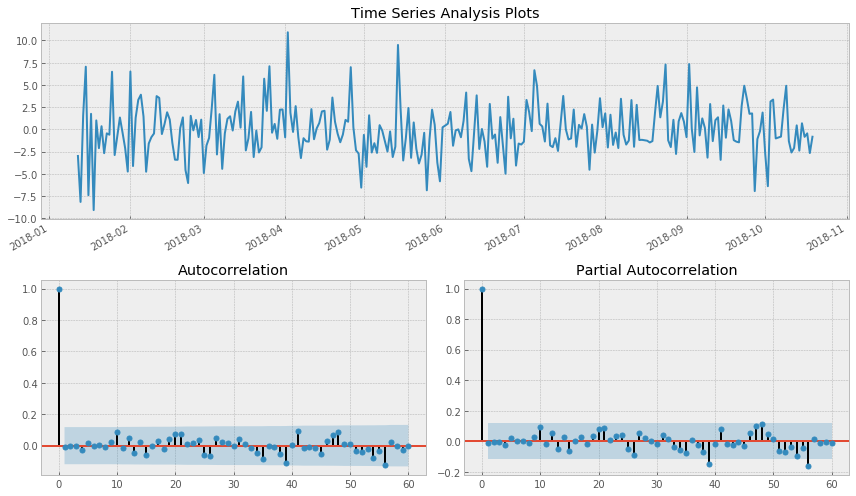

In [124]:
tsplot(best_model.resid[7+1:], lags=60)

In [125]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [131]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
 #   data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error = mean_absolute_percentage_error(np.array(data['calls'][s+d:]), np.array(data['arima_model'][s+d:]))

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="calls")
    plt.legend()
    plt.grid(True);

AttributeError: 'int' object has no attribute 'toordinal'

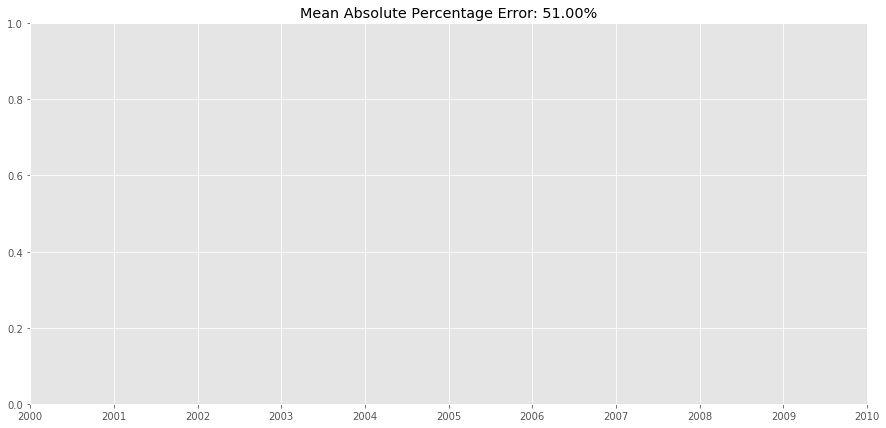

In [133]:
plotSARIMA( f , best_model, 250)